<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Suicide_Ideation/blob/master/Word_Clouds_Individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
!pip install bert-for-tf2

     |████████████████████████████████| 1.2MB 4.3MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=1776b3404539fdb3afe5b7afa66bb0e2cfe36e981c7816804fb77e0bf47794b6
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=69138135989ea2c2977a484b827f6732668978b9f354878e70fc52e62e89bdcc
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=e7bdcae2fa0e0d478afa5eca74675119d99ee6367cb869eaf8b67d604f55561a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [35]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os, re
import tensorflow_hub as hub
import tensorflow as tf
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
os.environ['KAGGLE_USERNAME'] = "nikhileswarkomati"
os.environ['KAGGLE_KEY'] = "001b3a30170775e55950edb6ff0c9b17"
!kaggle datasets download -d nikhileswarkomati/suicide-watch

suicide-watch.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '/content/suicide-watch.zip'

In [ ]:
data = pd.read_csv('/content/SuicideAndDepression_Detection.csv', lineterminator = '\n')
data.sample(5)

In [30]:
print(data.shape)
data['class'].value_counts()

(348111, 2)


depression      116037
teenagers       116037
SuicideWatch    116037
Name: class, dtype: int64

In [37]:
def preprocess(string):
    phrase = str(string)
    phrase = re.sub('[^a-z]+', ' ', phrase, flags = re.IGNORECASE)
    phrase = re.sub('(\s+)', ' ', phrase)
    phrase = re.sub('http\S+', ' ', phrase)
    phrase = phrase.lower()
    # words_li = ['suicide', 'kill', 'depression', 'fuck', 'filler', 'die', 'depressed']
    li = list(stopwords.words()) #+ words_li
    text_tokens = word_tokenize(phrase)
    return " ".join([word for word in text_tokens if word not in li])
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

59527144


In [ ]:
data['text'] = data['text'].map(lambda string: preprocess(string))

In [ ]:
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

59527144


In [32]:
X = data.iloc[:, 0].values
y = data.iloc[:, 1].values

le = LabelEncoder()

y = le.fit_transform(y)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.5, stratify = y)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, train_size = 0.05, stratify = train_y)
print(train_X.shape, test_y.shape, val_X.shape)

(8702,) (174056,) (165353,)


In [5]:
data.iloc[:5, 0].values

array(["Does life actually work for most / non-depressed people?It doesn't seem possible to me that everyone isn't miserable. What do you think? My boyfriend told me the other week that in reality we are the minority. Most people are fine, if not happy. Oddball.",
       "I found my friend's bodyIt was almost nine years ago now, but I still think about it every day. He was down about something so I sat with him and chatted, tried to cheer him up. He said he was fine, had just had a bit too much to drink, and that I should go to bed. That night he hanged himself in the tiny utility room of the house we shared. My ex saw him first, then yelled for me. I had to cut him down. The emergency services lady on the phone offered to talk me through attempting CPR, but I knew there was no point as he was frozen solid. I still feel I should have tried anyway, stupid as that is.\n\nI was really messed up for years afterwards. I mean, I was slightly depressed before that anyway (undiagnosed anaemia,

In [38]:
embeddings = embed([preprocess(ele) for ele in data.iloc[:10000, 0].values])
train_y = le.fit_transform(data.iloc[:10000, 1].values)
test_embeddings = embed([preprocess(ele) for ele in data.iloc[10000:15000, 0].values])
test_y = le.transform(data.iloc[10000:15000, 1].values)

In [39]:
from sklearn.linear_model import SGDClassifier



sgd = SGDClassifier()

sgd.fit(embeddings, train_y)
print("---------TRAINING_________DONE--------------")

y_pred = sgd.predict(test_embeddings)
print(accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

---------TRAINING_________DONE--------------
0.7508
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1638
           1       0.74      0.65      0.69      1702
           2       0.81      0.92      0.86      1660

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000



In [40]:


xgb = XGBClassifier()

xgb.fit(embeddings, train_y)
print("---------TRAINING_________DONE--------------")

y_pred = xgb.predict(test_embeddings)
print(accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

---------TRAINING_________DONE--------------
0.7338
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      1638
           1       0.69      0.66      0.68      1702
           2       0.83      0.88      0.85      1660

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [ ]:
xgb1 = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])

xgb1.fit(train_X, train_y)
y_pred = xgb1.predict(test_X)

print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.7400140758082817
              precision    recall  f1-score   support

           0       0.72      0.65      0.69     23207
           1       0.73      0.66      0.69     23208
           2       0.77      0.91      0.83     23208

    accuracy                           0.74     69623
   macro avg       0.74      0.74      0.74     69623
weighted avg       0.74      0.74      0.74     69623



In [ ]:
from sklearn.linear_model import SGDClassifier

sgd2 = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier()),
              ])

sgd2.fit(train_X, train_y)
y_pred = sgd2.predict(test_X)

print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.796389124283642
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     23207
           1       0.77      0.71      0.74     23208
           2       0.84      0.93      0.89     23208

    accuracy                           0.80     69623
   macro avg       0.79      0.80      0.79     69623
weighted avg       0.79      0.80      0.79     69623



In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-19 12:59:39--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.75.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.75.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  69.4MB/s    in 23s     

2021-04-19 13:00:02 (67.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [ ]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        #logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
for i in range(train_X.shape[0]):
    train_X[i] = w2v_tokenize_text(train_X[i])

for i in range(test_X.shape[0]):
    test_X[i] = w2v_tokenize_text(test_X[i])


In [ ]:
X_train_word_average = word_averaging_list(wv,train_X)
X_test_word_average = word_averaging_list(wv,test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, solver = 'newton-cg')
logreg = logreg.fit(X_train_word_average, train_y)
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred))

accuracy 0.7603665455381124
              precision    recall  f1-score   support

           0       0.72      0.68      0.69     23208
           1       0.69      0.75      0.72     23208
           2       0.88      0.86      0.87     23207

    accuracy                           0.76     69623
   macro avg       0.76      0.76      0.76     69623
weighted avg       0.76      0.76      0.76     69623



In [25]:
import itertools


%matplotlib inline


from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# max_words = 750
# tokenize = text.Tokenizer(num_words=max_words, char_level=False)
# tokenize.fit_on_texts(train_X) # only fit on train

# x_train = tokenize.texts_to_matrix(train_X)
# x_test = tokenize.texts_to_matrix(test_X)

num_classes = 3
y_train = utils.to_categorical(train_y, num_classes)
y_test = utils.to_categorical(test_y, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(512,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(embeddings, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    callbacks = [checkpoint, earlystopping],
                    validation_split=0.1)


Epoch 1/20
282/282 [==============================] - 2s 6ms/step - loss: 0.7249 - accuracy: 0.6678 - val_loss: 0.5025 - val_accuracy: 0.8050

Epoch 00001: val_accuracy improved from -inf to 0.80500, saving model to model.h5
Epoch 2/20
282/282 [==============================] - 1s 4ms/step - loss: 0.5125 - accuracy: 0.7860 - val_loss: 0.5005 - val_accuracy: 0.8060

Epoch 00002: val_accuracy improved from 0.80500 to 0.80600, saving model to model.h5
Epoch 3/20
282/282 [==============================] - 1s 5ms/step - loss: 0.4856 - accuracy: 0.7914 - val_loss: 0.4941 - val_accuracy: 0.8080

Epoch 00003: val_accuracy improved from 0.80600 to 0.80800, saving model to model.h5
Epoch 4/20
282/282 [==============================] - 1s 5ms/step - loss: 0.4858 - accuracy: 0.7964 - val_loss: 0.5049 - val_accuracy: 0.8080

Epoch 00004: val_accuracy did not improve from 0.80800
Epoch 5/20
282/282 [==============================] - 1s 4ms/step - loss: 0.4622 - accuracy: 0.8052 - val_loss: 0.5159 - 

In [26]:
y_pred = model.predict(test_embeddings)

In [27]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print(accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

0.7876
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1585
           1       0.73      0.73      0.73      1698
           2       0.91      0.88      0.90      1717

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



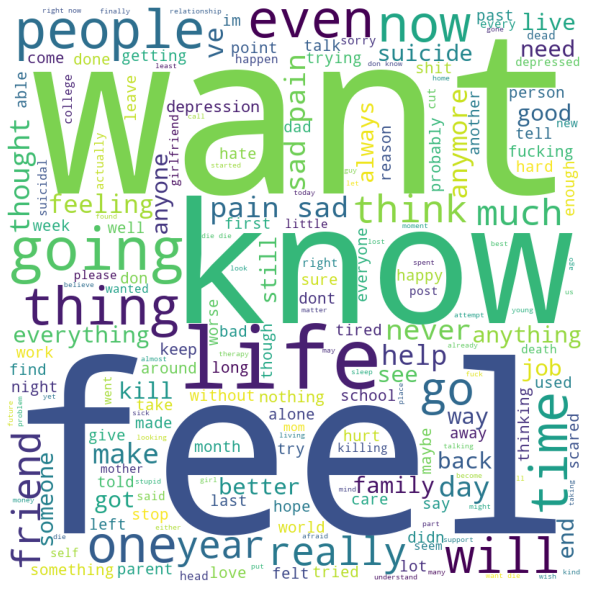

In [43]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

# Reads 'Youtube04-Eminem.csv' file 

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in data.loc[(data['class'] == 'SuicideWatch'), 'text'][:200]: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


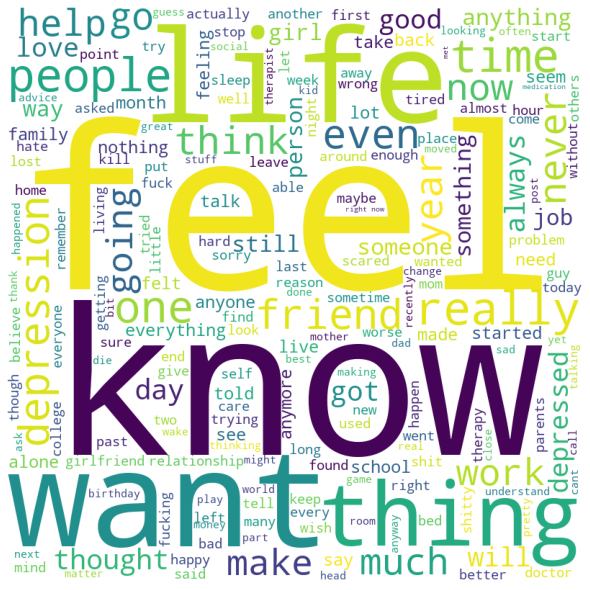

In [44]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

# Reads 'Youtube04-Eminem.csv' file 

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in data.loc[(data['class'] == 'depression'), 'text'][:200]: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


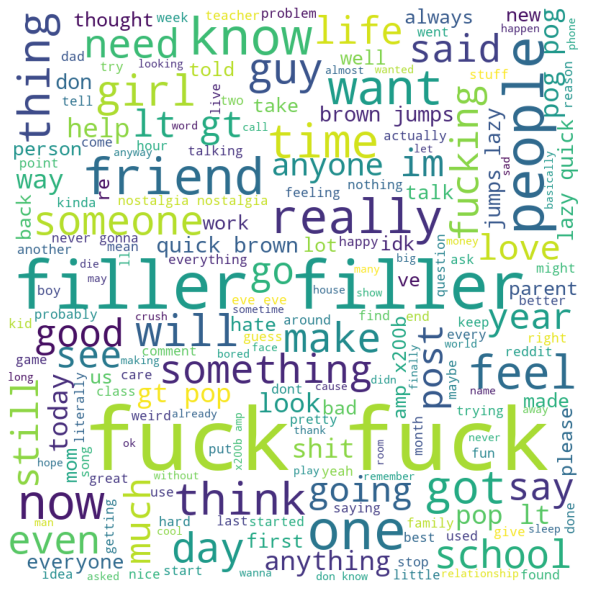

In [47]:
# Python program to generate WordCloud 

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

# Reads 'Youtube04-Eminem.csv' file 

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in data.loc[(data['class'] == 'teenagers'), 'text'][:5000]: 
	
	# typecaste each val to string 
	val = str(val) 

	# split the value 
	tokens = val.split() 
	
	# Converts each token into lowercase 
	for i in range(len(tokens)): 
		tokens[i] = tokens[i].lower() 
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
				background_color ='white', 
				stopwords = stopwords, 
				min_font_size = 10).generate(comment_words) 

# plot the WordCloud image					 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 
